In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fsps
import sedpy
import prospect
from prospect.utils.obsutils import fix_obs
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits

In [2]:
vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))
sedpy_filter_loc='/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/'
print(glob(sedpy_filter_loc+'*'))

numpy: 1.26.3
scipy: 1.11.4
h5py: 3.10.0
fsps: 0.4.6
prospect: 1.2.0
['/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/wise_w2.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/jwst_moda_f115w.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/subaru_suprimecam_ia767.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/subaru_suprimecam_zp.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/wfc3_uvis_f814w.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/uvot_w2.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/hipparcos_B.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/herschel_synthphot.pdf', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/f

In [3]:
Photometry=np.genfromtxt('./photometry.csv',delimiter=',',names=True,missing_values=np.nan)
targets={'NGC3705': np.asarray(list(Photometry[3])[1:]),
         'MCG05': np.asarray(list(Photometry[0])[1:]),
         'MCG06': np.asarray(list(Photometry[1])[1:]),
         'UGC9374': np.asarray(list(Photometry[6])[1:]),
         'NVSSJ09': np.asarray(list(Photometry[5])[1:]),
         'NGC6365A': np.asarray(list(Photometry[4])[1:]),
         'NGC3016': np.asarray(list(Photometry[2])[1:])}
filternames=['galex_FUV','galex_NUV','sdss_u0','Johnson_B','Johnson_V',\
    'Cousins_R','sdss_i0','sdss_z0','twomass_J','twomass_H','twomass_Ks','wise_w1','wise_w2',\
        'wise_w3','wise_w4','AKARI_FIS_N60','AKARI_FIS_WIDE-S','AKARI_FIS_WIDE-L','AKARI_FIS_N160']
print(targets['NGC3016'][::2])
print(targets['NGC3016'][1::2])

[16.5   16.03  14.93  13.83  13.17  12.7   12.747 12.569 12.26  12.1
 12.21  13.789 14.336 12.486 11.984    nan  9.05   7.84     nan]
[0.03  0.02  0.01  0.01  0.01  0.01  0.001 0.002 0.03  0.04  0.04  0.022
 0.02  0.017 0.041   nan 0.08  0.78    nan]


In [15]:
testspec=fits.open('./SDSS_Spec/spec_MCG05.fits')[1].data
print(len(fits.open('./SDSS_Spec/spec_MCG05.fits')))

10


[ 47.200314  45.991528  46.545147 ... 100.69298  106.44819  105.70641 ]
[0 0 0 ... 0 0 0]


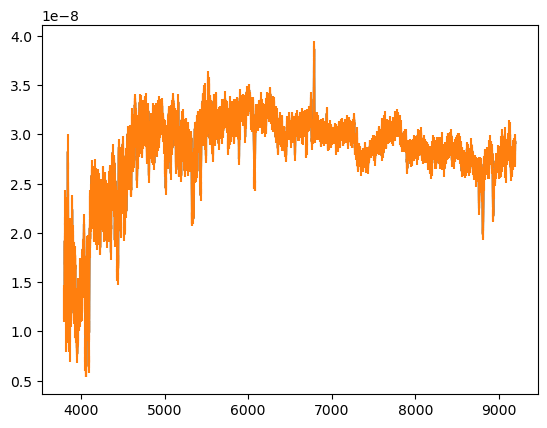

In [73]:
print(testspec['flux'])
plt.plot(10**testspec['loglam'],(10**(-6))*testspec['flux']/3631)
#plt.errorbar(10**testspec['loglam'],(10**(-6))*testspec['flux']/3631,yerr=(1/np.sqrt((10**(-6))*testspec['ivar']/3631)))
plt.errorbar(10**testspec['loglam'],(10**(-6))*testspec['flux']/3631,yerr=10**(-6)/(np.sqrt(testspec['ivar'])*3631))
#plt.plot(10**testspec['loglam'],(10**(-6))*testspec['sky']/3631)
print(testspec['and_mask'])

In [66]:
target='NGC3016'
obs={}
obs['filters']=sedpy.observate.load_filters(filternames)
obs['maggies']=list(10**(-0.4*targets[target][::2]))
obs['maggies_unc']=0.921*targets[target][1::2]*obs['maggies']
spec=fits.open(f'./SDSS_Spec/spec_{target}.fits')[1].data
i=0
while i<len(obs['maggies']):
    if np.isnan(obs['maggies'][i])==True:
        del obs['filters'][i]
        obs['maggies']=np.delete(obs['maggies'],i)
        obs['maggies_unc']=np.delete(obs['maggies_unc'],i)
        i+=1
    i+=1
#print(obs['maggies'])
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
obs['wavelength']=10**spec['loglam']
obs['spectrum']=(10**(-7))*spec['flux']/3631
obs['unc']=10**(-7)/(np.sqrt(spec['ivar'])*3631)
obs['mask']=spec['and_mask']
obs['rescale_spectrum']=False
obs=fix_obs(obs)
print(obs)




{'filters': [<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(Johnson_B), <class 'sedpy.observate.Filter'>(Johnson_V), <class 'sedpy.observate.Filter'>(Cousins_R), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-S), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-L)], 'maggies': array([2.51188643e-07, 3.87257645e-07, 1.06659612e-06, 2.93764965e-06,
       5.39510623e-06, 8.31763771e-06, 7.96526080e-06, 9.38425931e-06,
       1.24738351e-05, 1.44543977e-05, 1.30617089e-05, 3.05070350e-

/tmp/ipykernel_838/3622745931.py:19: RuntimeWarning: divide by zero encountered in divide
  obs['unc']=10**(-7)/(np.sqrt(spec['ivar'])*3631)


Obs Dictionary Keys:

dict_keys(['filters', 'maggies', 'maggies_unc', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'mask', 'rescale_spectrum', 'phot_mask', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(Johnson_B), <class 'sedpy.observate.Filter'>(Johnson_V), <class 'sedpy.observate.Filter'>(Cousins_R), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-S), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-L)]


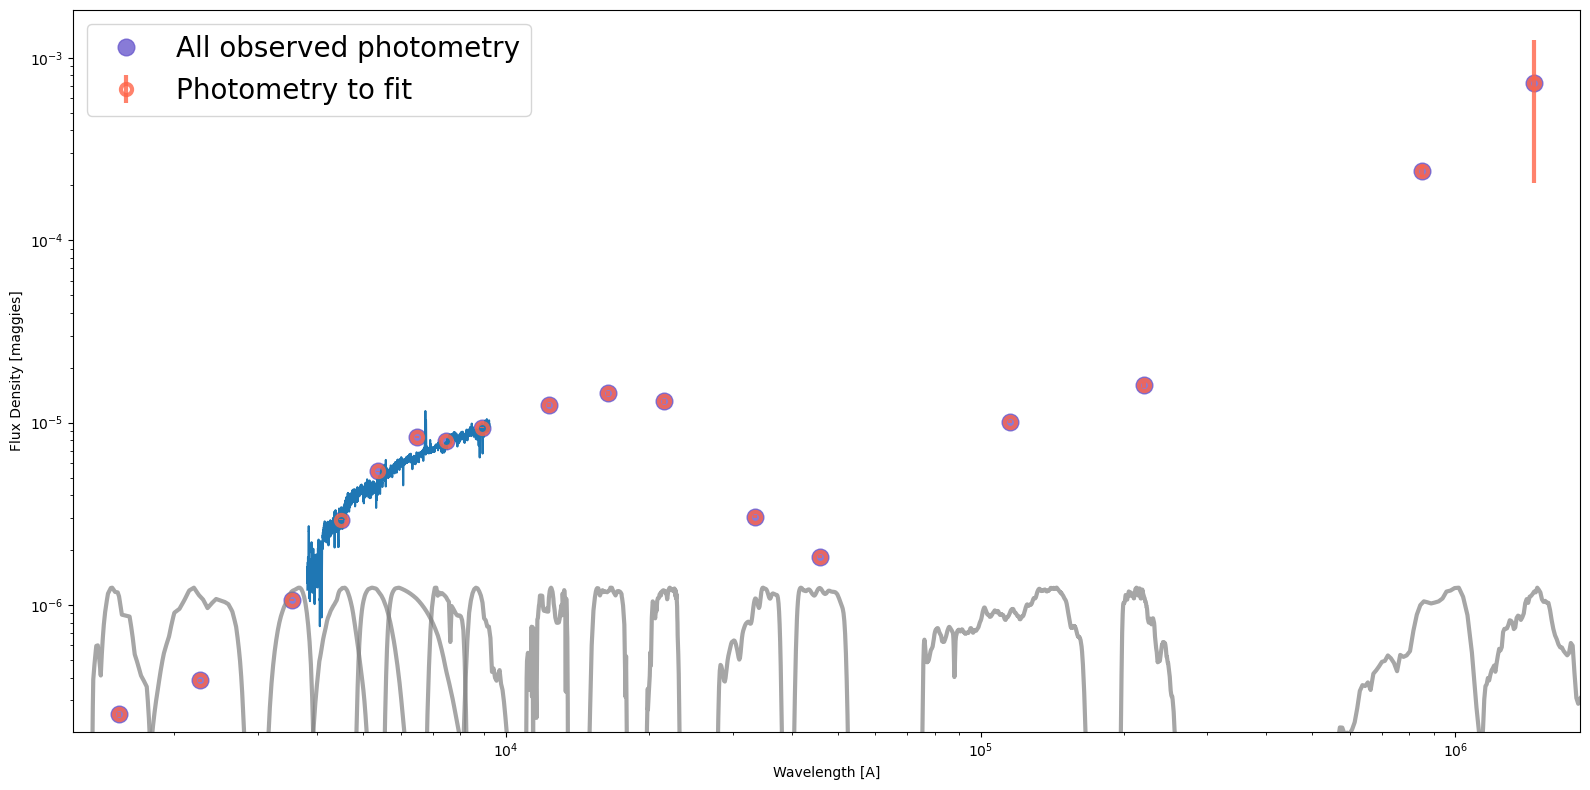

In [75]:
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(16,8))

# plot all the data
plt.plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')
plt.plot(obs['wavelength'],0.4*obs['wavelength']*obs['spectrum'])

# overplot only the data we intend to fit
mask = obs["phot_mask"]
plt.errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()